In [8]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from dosipy.utils.viz import fig_config, save_fig

In [21]:
color = sns.color_palette(palette='rocket', n_colors=2).as_hex()

In [2]:
#set_colorblind()
%config InlineBackend.figure_format = as_hexetina'

In [3]:
def rpd(comp, ref):
    """Relative percentage difference."""
    comp = np.asarray(comp)
    ref = np.asarray(ref)
    val = (comp - ref) / ref * 100
    return val.round(2)

In [37]:
labels = ['26 GHz', '60 GHz\n(A = 4 cm2)', '60 GHz\n(A = 1 cm2)']
y = np.arange(len(labels))
width = 0.5

ref = [5.3, 6.22, 6.22]
tpd_pol_1 = [5.93, 6.1, 6.64]
rpd_tpd_pol_1 = rpd(tpd_pol_1, ref)
apd_pol_1 = [5.61, 5.83, 6.61]
rpd_apd_pol_1 = rpd(apd_pol_1, ref)
tpd_pol_2 = [4.75, 5.82, 7.48]
rpd_tpd_pol_2 = rpd(tpd_pol_2, ref)
apd_pol_2 = [4.60, 5.71, 7.39]
rpd_apd_pol_2 = rpd(apd_pol_2, ref)

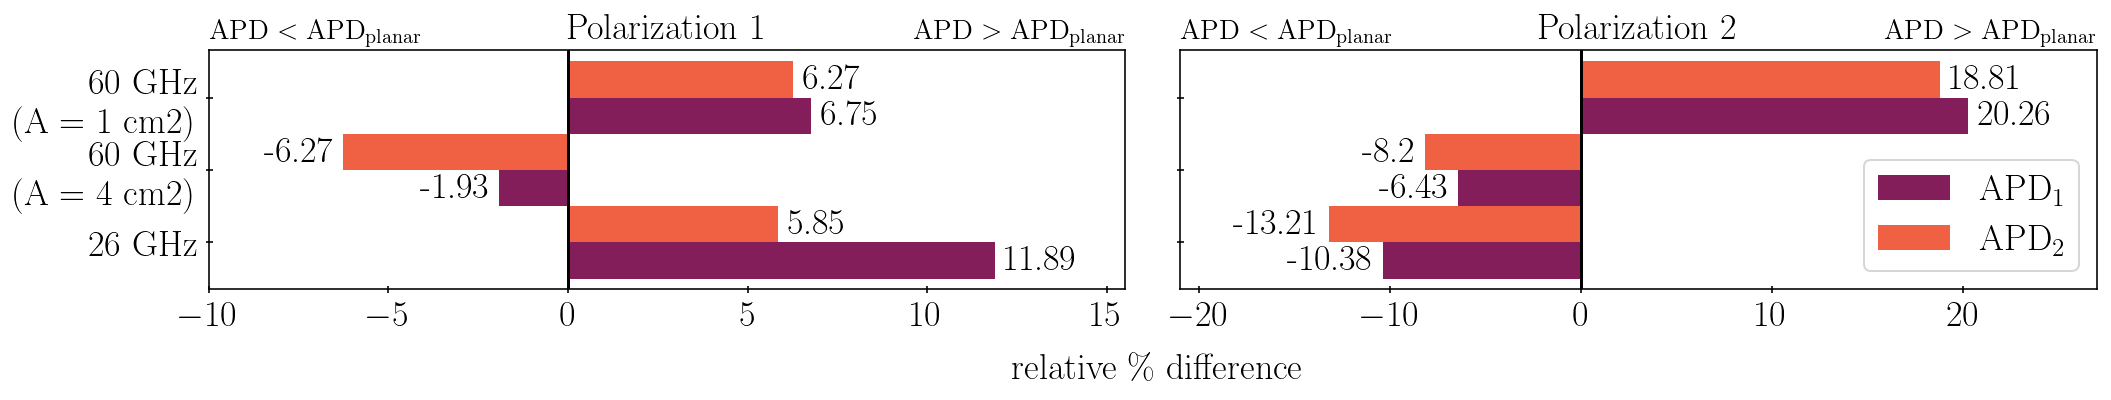

In [38]:
fig_config(latex=True, text_size=18)
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 2.75))
rects_tpd_1 = axs[0].barh(y - width/2, rpd_tpd_pol_1, width, color=color[0], label=r'$\text{APD}_1$')
rects_apd_1 = axs[0].barh(y + width/2, rpd_apd_pol_1, width, color=color[1], label=r'$\text{APD}_2$')
axs[0].axvline(x=0, lw=1.5, color='k')
rects_tpd_2 = axs[1].barh(y - width/2, rpd_tpd_pol_2, width, color=color[0], label=r'$\text{APD}_1$')
rects_apd_2 = axs[1].barh(y + width/2, rpd_apd_pol_2, width, color=color[1], label=r'$\text{APD}_2$')
axs[1].axvline(x=0, lw=1.5, color='k')

axs[0].bar_label(rects_tpd_1, padding=5)
axs[0].bar_label(rects_apd_1, padding=5)
axs[0].set(xlim=[-10, 15.5],
           yticks=y,
           yticklabels=labels)
axs[0].set_title('Polarization 1', loc='center', fontweight='bold')
axs[0].set_title(r'$\text{APD} < \text{APD}_\text{planar}$', loc='left', fontsize=14)
axs[0].set_title(r'$\text{APD} > \text{APD}_\text{planar}$', loc='right', fontsize=14)
axs[0].tick_params(axis='both', direction="inout")

axs[1].bar_label(rects_tpd_2, padding=5)
axs[1].bar_label(rects_apd_2, padding=5)
axs[1].set(xlim=[-21, 27],
           yticks=y,
           yticklabels=labels)
axs[1].set_title('Polarization 2', loc='center', fontweight='bold')
axs[1].set_title(r'$\text{APD} < \text{APD}_\text{planar}$', loc='left', fontsize=14)
axs[1].set_title(r'$\text{APD} > \text{APD}_\text{planar}$', loc='right', fontsize=14)
axs[1].tick_params(axis='both', direction="inout")
axs[1].legend(loc='lower right')

fig.text(0.48, -0.02, s='relative \% difference')
fig.tight_layout()

# fname = os.path.join('figures', 'visual_summary')
# save_fig(fig, fname=fname, formats=['png'])